# Image reconstruction by localized impainting for anomaly detection

This notebook assumes the existence of a Dataset folder in the same parent directory, containing annotations, images, and a labels.csv file containing the mapping of images to labels.

In [1]:
!pip install tensorflow_addons
!pip install tensorflow_io
!pip install opencv-python

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import pandas as pd
import cv2
import os
import sys
import torch 
import random
import tensorflow_addons as tfa
import tensorflow_io as tfio

from tensorflow import keras
from tensorflow.keras import layers, activations
from sklearn import metrics
from torchvision import transforms
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score

2022-10-26 18:11:15.526005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 18:11:15.682450: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 18:11:16.321096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-26 18:11:16.321170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Data processing

We here read the data and pre-process it. In particular, we convert the provided coordinates from yolo format to the coordinates of the top-left and bottom-right corner of the bbox, and we use them to impaint the images that have been read and resized to 256x256. Thus, we split data into train, validation, and test by assigning only negative instances to the first two, and both positive and negative instances to the third set, and by making sure that images related to the same patient do not appear in more than one set. 

In [2]:
''' pre-processing functions '''
IMG_WIDTH    = 256
IMG_HEIGHT   = 256
IMG_CHANNELS = 3
size = (IMG_WIDTH,IMG_HEIGHT)

def getpatient(x):
    return x.split('_')[0]

def read_and_resize(path, size=(IMG_WIDTH,IMG_HEIGHT)):
    image   = cv2.imread(path)
    image   = cv2.resize(image, size)
    return image

def xywh2xyxy(yolo_coords, width=256, height=256):
    if len(yolo_coords) == 4:
        x, y, w, h  = yolo_coords
        x1 = (x - w / 2)*width
        y1 = (y - h / 2)*height
        x2 = (x + w / 2)*width
        y2 = (y + h / 2)*height
        coords = [x1, y1, x2, y2]
        coords = [int(c) for c in coords]
    else: 
        coords = ''
    return coords


def mask_image(image, mask_coords = [110, 150, 150, 110]):
    mask_color = (0, 0, 0) # black
    x, y, w, z = mask_coords
    copy_image = image.copy()
    if tf.is_tensor(image):                                   # convert to numpy for masking
        copy_image = copy_image.numpy()
    cv2.rectangle(copy_image, (x, y), (w, z), mask_color, -1) # mask
    if tf.is_tensor(image):                                   # back to tensor
        copy_image = tf.constant(copy_image)
    return copy_image


''' normalization functions '''
def normalize(X, which_range='0/1'):
        if which_range == '-1/1':
            print('')
            # normalization
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
            a = []
            for img in X:
                tensor = transform(img)
                tensor = tensor.unsqueeze(0)
                a.append(tensor)
            X_torch = torch.cat(a)
            X_array = np.array(X_torch)
            X_tf = tf.transpose(X_array, perm=[0, 2, 3, 1])
            
        elif which_range == '0/1':
            X_tf = layers.Rescaling(1./255)(X)
            
        return X_tf

In [3]:
def get_df():
    # read labels.csv
    data = pd.read_csv('../Dataset/labels.csv', delimiter=';')

    path_to_coords = "../Dataset/annotations"
    coords_list      = [] 
    yolo_coords_list = []
    patient_id       = []

    for f_name in data['Filename']: 
        patient_id.append(getpatient(f_name))
        path_to_file = f'{path_to_coords}/{f_name[:-4]}.txt'
        if os.path.exists(path_to_file):
            with open(path_to_file) as file:
                yolo_coords = file.read()
                yolo_coords = yolo_coords[2:]
                floats = [float(x) for x in yolo_coords.split()]
                coords = xywh2xyxy(floats)
                coords_list.append(coords)
                yolo_coords_list.append(floats)
        else: 
            coords_list.append([])
            yolo_coords_list.append([])

    # add to df
    data['Coords']      = coords_list
    data['yolo_Coords'] = yolo_coords_list
    data['Patient_id']  = patient_id

    # check and remove images with no coordinates: 4
    n_missing = len(data.loc[data['Coords'] == ''])
    print(f'images with missing coords: {n_missing}')
    data = data.loc[data['Coords'] != '']

    # # - plot confidence by class
    # g = sns.catplot(data = data, kind="count", x="Confidence", hue="Effusion")
    # plt.savefig('../figures/confidence_by_class.pdf')

    # - split by class
    positive_df = data.loc[data['Effusion'] == 'yes']
    negative_df = data.loc[data['Effusion'] == 'no']

    # split train and test
    splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
    split = splitter.split(negative_df, groups=negative_df['Patient_id'])
    train_inds, test_inds = next(split)
    train = negative_df.iloc[train_inds]
    test_neg = negative_df.iloc[test_inds]

    # split train and validation
    split = splitter.split(train, groups = train['Patient_id'])
    train_inds, valid_inds = next(split)

    train_df = train.iloc[train_inds]
    valid_df = train.iloc[valid_inds]
    test_df  = pd.concat([test_neg, positive_df])

    # - shuffle
    train_df = train_df.sample(frac=1, random_state=30)
    valid_df = valid_df.sample(frac=1, random_state=30)
    test_df  = test_df.sample(frac=1,  random_state=30)

    # remove damaged files
    strange_files = ['6zdHuYzvPLz2yk9EwvPujn_0000_0013.png', 
                     '3FwpLf3L6CxgJpSdtbMZCQ_0000_0023.png']
    train_df = train_df[train_df.Filename != strange_files[0]]
    train_df = train_df[train_df.Filename != strange_files[1]]
    
    # reset index
    train_df = train_df.reset_index()
    valid_df = valid_df.reset_index()
    test_df  = test_df.reset_index()

    return train_df, valid_df, test_df


def transform_data(df, which_range):
    
    # get image files
    path_to_images = "../Dataset/images"
    Y = [f'{path_to_images}/{image}' for image in df['Filename']]
    
    # read, resize, reshape 
    Y = map(read_and_resize, Y)
    Y = np.array(list(Y)).reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    
    # mask images to create X, leave Y as original image
    X = map(mask_image, Y, df['Coords'])
    X = np.array(list(X)).reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    
    # normalization
    X = normalize(X, which_range)
    Y = normalize(Y, which_range)
    
    return X, Y


In [4]:
# get the transformed data 
train_df, valid_df, test_df = get_df()
which_norm = '0/1'

X_train, Y_train = transform_data(train_df, which_norm)
X_valid, Y_valid = transform_data(valid_df, which_norm)
X_test, Y_test   = transform_data(test_df,  which_norm)

images with missing coords: 4


2022-10-26 18:26:40.741615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 18:26:40.765207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 18:26:40.766079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 18:26:40.767217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Let's make some check on data to make sure they are as desired

In [5]:
## normalization
for X in [X_train, X_valid, X_test]:
    if which_norm == '0/1':
        assert tf.reduce_min(X) == 0 and tf.reduce_max(X) == 1
    else:
        assert tf.reduce_min(X) == -1 and tf.reduce_max(X) == 1
    
## patients id
assert set(train_df['Patient_id']) != set(valid_df['Patient_id'])
assert set(valid_df['Patient_id']) != set(test_df['Patient_id'])
assert set(train_df['Patient_id']) != set(test_df['Patient_id'])

## positives and negatives distribution
assert set(train_df['Effusion']) == {'no'} and set(valid_df['Effusion']) == {'no'} and set(test_df['Effusion']) == {'no','yes'}

## Loss functions
We now define the required loss functions. 
First, we modify the source code of prewitt filter from tensorflow addons to avoid vanishing gradients.

In [17]:
# modify source of prewitt
def pad(input, ksize, mode, constant_values):
    input = tf.convert_to_tensor(input)
    ksize = tf.convert_to_tensor(ksize)
    mode = "CONSTANT" if mode is None else upper(mode)
    constant_values = (
        tf.zeros([], dtype=input.dtype)
        if constant_values is None
        else tf.convert_to_tensor(constant_values, dtype=input.dtype)
    )

    assert mode in ("CONSTANT", "REFLECT", "SYMMETRIC")

    height, width = ksize[0], ksize[1]
    top = (height - 1) // 2
    bottom = height - 1 - top
    left = (width - 1) // 2
    right = width - 1 - left
    paddings = [[0, 0], [top, bottom], [left, right], [0, 0]]
    return tf.pad(input, paddings, mode=mode, constant_values=constant_values)


def prewitt(input, mode=None, constant_values=None, name=None):
    """
    Apply Prewitt filter to image.
    Args:
      input: A 4-D (`[N, H, W, C]`) Tensor.
      mode: A `string`. One of "CONSTANT", "REFLECT", or "SYMMETRIC"
        (case-insensitive). Default "CONSTANT".
      constant_values: A `scalar`, the pad value to use in "CONSTANT"
        padding mode. Must be same type as input. Default 0.
      name: A name for the operation (optional).
    Returns:
      A 4-D (`[N, H, W, C]`) Tensor.
    """

    input = tf.convert_to_tensor(input)

    gx = tf.cast([[1, 0, -1], [1, 0, -1], [1, 0, -1]], input.dtype)
    gy = tf.cast([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], input.dtype)

    ksize = tf.constant([3, 3])

    input = pad(input, ksize, mode, constant_values)

    channel = tf.shape(input)[-1]
    shape = tf.concat([ksize, tf.constant([1, 1], ksize.dtype)], axis=0)
    gx, gy = tf.reshape(gx, shape), tf.reshape(gy, shape)
    shape = tf.concat([ksize, [channel], tf.constant([1], ksize.dtype)], axis=0)
    gx, gy = tf.broadcast_to(gx, shape), tf.broadcast_to(gy, shape)

    x = tf.nn.depthwise_conv2d(
        input, tf.cast(gx, input.dtype), [1, 1, 1, 1], padding="VALID"
    )
    y = tf.nn.depthwise_conv2d(
        input, tf.cast(gy, input.dtype), [1, 1, 1, 1], padding="VALID"
    )
    epsilon = 1e-08
    return tf.math.sqrt(x * x + y * y + sys.float_info.epsilon)           # added '+ sys.float_info.epsilon'

In [18]:
""" pick the right function """
def which_loss(loss_fn):
    switcher = {
        'mse':      "mse",
        'L2':       L2_Loss,
        'SSIM':     SSIM_Loss,
        'MSGMS':    MSGMS_Loss,
        'COMBINED': COMBINED_Loss,
    }
    return switcher.get(loss_fn, "Invalid loss function")


""" Gradient Magnitude Map """
def Grad_Mag_Map(I, show = False):
    I = tf.reduce_mean(I, axis=-1, keepdims=True)
    I = tfa.image.median_filter2d(I, filter_shape=(3, 3), padding='REFLECT')
    x = prewitt(I)
    if show:
        x = tf.squeeze(x, axis=0).numpy()
    return x


""" Gradient Magnitude Similarity Map"""
def GMS(I, I_r, show=False, c=0.0026):
    g_I   = Grad_Mag_Map(I)
    g_Ir  = Grad_Mag_Map(I_r)
    similarity_map = (2 * g_I * g_Ir + c) / (g_I**2 + g_Ir**2 + c)
    if show:
        similarity_map = tf.squeeze(similarity_map, axis=0).numpy()
    return similarity_map


""" Gradient Magnitude Distance Map"""
def GMS_Loss(I, I_r):
    x = tf.reduce_mean(1 - GMS(I, I_r)) 
    return x


#### LOSS FUNCTIONS ####
""" Define MSGMS """
def MSGMS_Loss(I, I_r):
    # normal scale loss
    tot_loss = GMS_Loss(I, I_r)
    # pool 3 times and compute GMS
    for _ in range(3):
        I   = tf.nn.avg_pool2d(I,   ksize=2, strides=2, padding= 'VALID')
        I_r = tf.nn.avg_pool2d(I_r, ksize=2, strides=2, padding= 'VALID')
        # sum loss
        tot_loss += GMS_Loss(I, I_r)

    return tot_loss/4


""" Define SSIM loss"""
def SSIM_Loss(I, I_r):
    I   = tf.cast(I,   dtype=tf.double)
    I_r = tf.cast(I_r, dtype=tf.double)
    img_range = tf.reduce_max(X_train)-tf.reduce_min(X_train)
    ssim = tf.image.ssim(I, I_r, max_val=img_range, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    return tf.reduce_mean(1 - ssim)


""" Define l2 loss"""
def L2_Loss(I, I_r):
    l2_loss = tf.keras.losses.MeanSquaredError()
    return l2_loss(I, I_r)


""" Define total loss"""  
def COMBINED_Loss(I, I_r, lambda_s=1.0, lambda_m=1.0):
    l2_loss = L2_Loss(I, I_r)
    S_loss  = SSIM_Loss(I, I_r)
    M_loss  = MSGMS_Loss(I, I_r)

    x = lambda_s * S_loss + lambda_m * M_loss + l2_loss
    return tf.reduce_mean(x)


""" Define total weighted loss""" 
def COMBINED_W_Loss(lambda_s):
    def COMBINED_Loss(I, I_r):
        l2_loss = L2_Loss(I, I_r)
        S_loss  = SSIM_Loss(I, I_r)
        M_loss  = MSGMS_Loss(I, I_r)
        
        lambda_m = 1 - lambda_s

        x = lambda_s * S_loss + lambda_m * M_loss + l2_loss
        return tf.reduce_mean(x)
    return COMBINED_Loss

## Anomaly map

In [19]:
""" Define MSGMS Anomaly Map """

def Anomaly_Map(I, I_r):
    I   = tf.cast(I, dtype=tf.float32)
    I_r = tf.cast(I_r, dtype=tf.float32)
    # normal scale similarity map
    gms_tot = GMS(I, I_r)

    # pool 3 times and compute GMS
    for _ in range(3):
        I   = tf.nn.avg_pool2d(I, ksize=2, strides=2, padding= 'VALID')
        I_r = tf.nn.avg_pool2d(I_r, ksize=2, strides=2, padding= 'VALID')
        # compute GMS 
        gms_scale = GMS(I, I_r)
        # upsample
        gms_scale = tf.image.resize(gms_scale, size=size)
        gms_tot  += gms_scale

    gms_map = gms_tot/4
    gms_map = tfa.image.mean_filter2d(gms_map) 
    return (1 - gms_map).numpy()



## Model architecture

In [8]:
# Building blocks
def EncoderBlock(inputs, out_channels, kernel_size, stride):
    ## miniblock 1
    c1 = layers.Conv2D(out_channels, kernel_size, stride, 'same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation(activations.relu)(c1)
    # miniblock 2
    c1 = layers.Conv2D(out_channels, 3, 1, 'same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation(activations.relu)(c1)
    return c1

def DecoderBlock(up_input, down_input, out_channels):
    up_input = layers.Conv2DTranspose(out_channels, 4, 2, 'same')(up_input)
    inputs = layers.concatenate([up_input, down_input])

    ## miniblock 1
    c1 = layers.Conv2D(out_channels, 3, 1, 'same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation(activations.relu)(c1)
    # miniblock 2
    c1 = layers.Conv2D(out_channels, 3, 1, 'same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation(activations.relu)(c1)
    return c1



# Model
def AutoEncoder(activation):
    
    # input layer with normalization and standardization
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    latent_dim = 512

    # Encoding path
    e1 = EncoderBlock(inputs,  64, 3, 1)
    e2 = EncoderBlock(e1,     128, 4, 2)
    e3 = EncoderBlock(e2,     256, 4, 2)

    # Latent dimension
    e4 = EncoderBlock(e3, latent_dim, 4, 2)
    e5 = EncoderBlock(e4, latent_dim, 4, 2)
    d1 = DecoderBlock(e5, e4, latent_dim)

    # Dencoding path 
    d2 = DecoderBlock(d1, e3, 256)
    d3 = DecoderBlock(d2, e2, 128)
    d4 = DecoderBlock(d3, e1, 64)

    # final convolution 
    d5 = layers.Conv2D(IMG_CHANNELS, 3, 1, 'same')(d4)

    if activation   == 'relu':
        outputs = tf.keras.activations.relu(d5)
    elif activation == 'tanh':
        outputs = layers.Activation(activations.tanh)(d5)
    elif activation == 'sigmoid': 
        outputs = tf.keras.activations.sigmoid(d5)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


## Training
Let's define a function for training which save the best weigths based on validation loss, the last model, and the training history.
Then, we can proceed with training our models by specifying the desired parameters and loss function.

In [9]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

2.10.0
Num GPUs: 1


In [10]:
def train_model(model, loss, activation, epochs, lr, lam):
    
    net_name = f'{loss}_{activation}_{epochs}'
    if loss == 'COMBINED_W':
        net_name = f'{net_name}_{lam}'

    # Set callbacks
    def scheduler(epoch):
        if epoch < 250:
            return lr
        else:
            return 0.00001

    change_lr  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    earlystop  = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, verbose=1)
    filepath   = f'../Models/best_weights/{net_name}_weights_best.hdf5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                                    save_best_only=True, mode='min')

    # Train
    start_train = datetime.datetime.now()
    print(f'Starting training for model {net_name} at: {start_train} :D')
    history = model.fit(X_train, Y_train, 
                        epochs = epochs, 
                        callbacks = [earlystop,checkpoint,change_lr],
                        validation_data = (X_valid, Y_valid), batch_size = 8)

    # Save history   
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = f'../Models/model_histories/{net_name}.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    # Save model
    model.save(f'../Models/trained_models/{net_name}')
    
    return model

In [ ]:
# -- set --
loss = 'COMBINED_W'
activation = 'sigmoid'
epochs = 300
lr = 0.0001
lam = 0

# Build model
loss_fn   = COMBINED_Loss(lam) if loss=='COMBINED_W' else which_loss(loss)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model     = AutoEncoder(activation)
model.compile(optimizer = optimizer, loss = loss_fn)
train_model(model, loss, activation, epochs, lr, lam)

## Validation
Once the models have been trained, we evaluate their performance on image reconstruction.

In [12]:
''' load model '''
def load_trained_model(loss, net_name, lam=0):
    loss_fn = COMBINED_W_Loss(lam) if loss=='COMBINED_W' else which_loss(loss)
    if loss=='COMBINED_W':
        loss = 'COMBINED'
    model   = tf.keras.models.load_model(f'../Models/best_weights/{net_name}_weights_best.hdf5',
                                       custom_objects={loss+'_Loss': loss_fn})
    return model


''' model evaluation '''    
def evaluate_model(model, X, Y):
    # Predict images on validation set
    Y_pred = model.predict(X)
    # Compute anomaly maps (discrimination ability)
    maps = Anomaly_Map(Y, Y_pred)
    # Compute anomaly scores
    anomaly_scores = [mapp.max() for mapp in maps]
    return  Y_pred, maps, anomaly_scores
    
    
''' plot history '''
def plot_loss(net_name):
    history = pd.read_csv(f'../Models/model_histories/{net_name}.csv')
    # plot loss
    plt.rcParams["figure.figsize"]=4,3
    plt.rcParams['font.size'] = '16'
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.yscale("log")
    plt.legend(['train', 'validation'], loc='upper right', prop={'size': 10})
    plt.show()
    


''' plot reconstruction fun '''
def plot_reconstruction(X_masked, Y_true, Y_pred_ls, index):
    masked    = X_masked[index]
    original  = Y_true[index]
    predicted = [Y_pred[index] for Y_pred in Y_pred_ls]

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12,4))
    plt.rcParams['font.size'] = '10'
    # plot masked
    ax1.imshow(masked, interpolation='nearest')
    ax1.title.set_text('masked')
    
    # plot original
    ax2.imshow(original, interpolation='nearest')
    ax2.title.set_text('original')

    # plot reconstructed 0
    ax3.imshow(predicted[0], interpolation='nearest')
    ax3.title.set_text('model0')
    # plot reconstructed 1
    ax4.imshow(predicted[1], interpolation='nearest')
    ax4.title.set_text('model1')
    # plot reconstructed 2
    ax5.imshow(predicted[2], interpolation='nearest')
    ax5.title.set_text('model2')
    # plot reconstructed 3
    ax6.imshow(predicted[3], interpolation='nearest')
    ax6.title.set_text('model3')

    fig.show()
    
    
    
''' plot anomaly maps fun '''
def plot_anomaly_maps(maps, params):
    scores = [round(float(mapp.max()),3) for mapp in maps]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
 
    ax1.imshow(maps[0], interpolation='nearest')
    ax1.set_title(f'{params[0]} loss - anomaly score: {scores[0]}', size = 10)
    
    ax2.imshow(maps[1], interpolation='nearest')
    ax2.set_title(f'{params[1]} loss - anomaly score: {scores[1]}', size = 10)
    plt.show()
    
    
''' plot scores density '''
def plot_density_validation(anomaly_scores_ls, params):
    
    df = pd.DataFrame({
    'scores0': anomaly_scores_ls[0],
    'scores1': anomaly_scores_ls[1],
    'scores2': anomaly_scores_ls[2],
    'scores3': anomaly_scores_ls[3]
    })
    
    means = [np.mean(scores) for scores in anomaly_scores_ls]
    plt.rcParams["figure.figsize"]=8,4
    plt.rcParams['font.size'] = '14'
    fig = sns.kdeplot(df['scores0'], fill=True, color="r")
    fig = sns.kdeplot(df['scores1'], fill=True, color="b")
    fig = sns.kdeplot(df['scores2'], fill=True, color="g")
    fig = sns.kdeplot(df['scores3'], fill=True, color="y")
    plt.axvline(x = means[0], color="r")
    plt.axvline(x = means[1], color="b")
    plt.axvline(x = means[2], color="g")
    plt.axvline(x = means[3], color="y")
    plt.legend(params, loc='upper right')
    plt.xlabel('anomaly score')


### Load models
We can load the models with the best weigths during training.

In [14]:
activation = 'sigmoid'
epochs = 300
models_ids  = ['model0','model1','model2','model3']
losses      = ['mse','COMBINED','COMBINED_W','COMBINED_W']

models_ls    = []
models_names = []
for i in range(len(models_ids)):
    loss = losses[i]
    net_name = f'{loss}_{activation}_{epochs}'
    lam = 0.25 if i == 2 else 0
    if i>=2: 
        net_name = f'{net_name}_{lam}'
        
    models_names.append(net_name)
    models_ls.append(load_trained_model(loss, net_name, lam))

models_ls

### Plot history

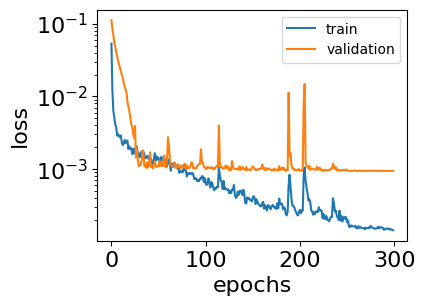

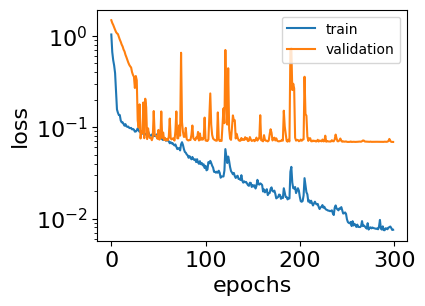

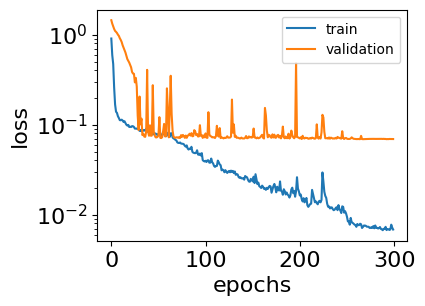

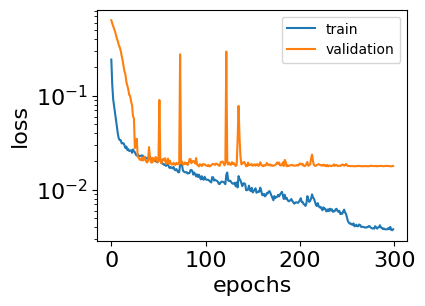

In [15]:
for i,model in enumerate(models_names):
    plot_loss(model)
    #plt.savefig(f'../figures/history_{models_ids[i]}.pdf',bbox_inches='tight')
    plt.show()

### Evaluate models
In order to evaluate the models we generate the predictions on the validation set, and the corresponding anomaly maps and scores.

In [20]:
Y_pred_ls      = []
maps_ls        = []
anomaly_scores_ls = []

for i,model in enumerate(models_ls):
    Y_pred, maps, anomaly_scores  = evaluate_model(model, X_valid, Y_valid)
    Y_pred_ls.append(Y_pred)
    maps_ls.append(maps)
    anomaly_scores_ls.append(anomaly_scores)
    print(f'mean anomaly score on negative examples,   {models_ids[i]}: {round(float(np.mean(anomaly_scores)),3)}')
    print(f'median anomaly score on negative examples, {models_ids[i]}: {round(float(np.median(anomaly_scores)),3)}')

2/2 [==============================] - 0s 216ms/step
mean anomaly score on negative examples,   model0: 0.63
median anomaly score on negative examples, model0: 0.639
2/2 [==============================] - 1s 216ms/step
mean anomaly score on negative examples,   model1: 0.623
median anomaly score on negative examples, model1: 0.613
2/2 [==============================] - 1s 216ms/step
mean anomaly score on negative examples,   model2: 0.61
median anomaly score on negative examples, model2: 0.608
2/2 [==============================] - 1s 216ms/step
mean anomaly score on negative examples,   model3: 0.55
median anomaly score on negative examples, model3: 0.549


Pre-task: reconstruction

In [ ]:
index = random.choice(range(len(valid_df)))

# run this cell to visualize reconstructions based on each model
print('reconstruction on example from validation set')
plot_reconstruction(X_valid, Y_valid, Y_pred_ls, index)

We want to find the model with the best reconstruction capacity on validation, so that we look at the lowest median and mean anomaly score values. The best model turns out to be Model3.

In [21]:
df = pd.DataFrame({
    'model': models_ids,
    'mean A_score':   [ np.mean(anomaly_scores_ls[i])   for i in range(len(models_ids)) ],
    'median A_score': [ np.median(anomaly_scores_ls[i]) for i in range(len(models_ids)) ]
    })

df

,model,mean A_score,median A_score
0,model0,0.629901,0.638978
1,model1,0.623498,0.613206
2,model2,0.609643,0.608174
3,model3,0.549612,0.548949


We can visualize the content of the previous table by plotting the density distributions of the anomaly scores on negative images. The distribution of Model3 is the most shifted towards low values.

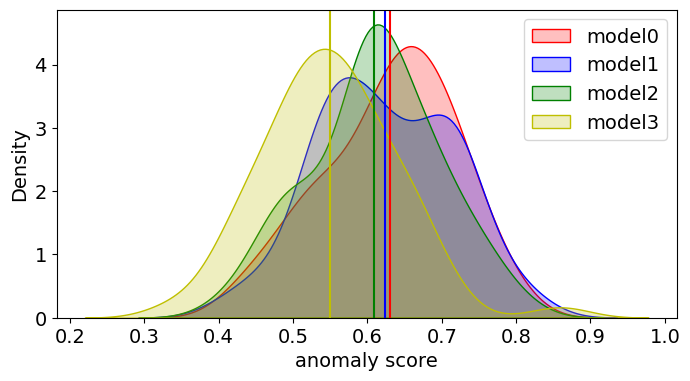

In [37]:
plot_density_validation(anomaly_scores_ls, models_ids)
plt.savefig('../figures/val_scores_density.pdf',bbox_inches='tight')
plt.show()

## Testing
We can finally assess the performance of our best model, Model3, on the real task of anomaly detection. We still produce results for the other models, to appreciate how the best model on the pretext-task also corresponds to the best model in anomaly detection on unseen data.

In [23]:
# positive and negative indexes:
pos_indices = test_df.index[test_df.Effusion == 'yes'].tolist()
neg_indices = test_df.index[test_df.Effusion == 'no'].tolist()

true_labels = test_df['Effusion']

# performance on test
Y_pred_test_ls         = []
maps_test_ls           = []
anomaly_scores_test_ls = []

for i, model in enumerate(models_ls):
    Y_pred, maps, anomaly_scores  = evaluate_model(model, X_test, Y_test)
    Y_pred_test_ls.append(Y_pred)
    maps_test_ls.append(maps)
    anomaly_scores_test_ls.append(anomaly_scores)

7/7 [==============================] - 1s 215ms/step


We can see how each model reconstructs a positive and a negative image. Run the cell to see the results.

In [ ]:
index = 15
pos_i = pos_indices[index]
neg_i = neg_indices[index]

# reconstruction
print('positive')
plot_reconstruction(X_test, Y_test, Y_pred_test_ls, pos_i)

print('negative')
plot_reconstruction(X_test, Y_test, Y_pred_test_ls, neg_i)

Find healthy and anomalous images with min and max anomaly score for Model3. This is useful to see how the model behaves on extreme cases.

In [41]:
m_id = 3
scores = anomaly_scores_test_ls[m_id]
pos_scores = [ scores[i] for i in pos_indices ]
neg_scores = [ scores[i] for i in neg_indices ]

min_pos       = np.min(pos_scores)
which_min_pos = scores.index(min_pos)
max_pos       = np.max(pos_scores)
which_max_pos = scores.index(max_pos)
min_neg       = np.min(neg_scores)
which_min_neg = scores.index(min_neg)
max_neg       = np.max(neg_scores)
which_max_neg = scores.index(max_neg)

print(f'positive images - min: {scores[which_min_pos]}, max: {scores[which_max_pos]}')
print(f'negative images - min: {scores[which_min_neg]}, max: {scores[which_max_neg]}')

positive images - min: 0.419419527053833, max: 0.9952197074890137
negative images - min: 0.3228573203086853, max: 0.7308727502822876


We can visualize the overlaying of the original images and their anomaly maps for such extreme cases.

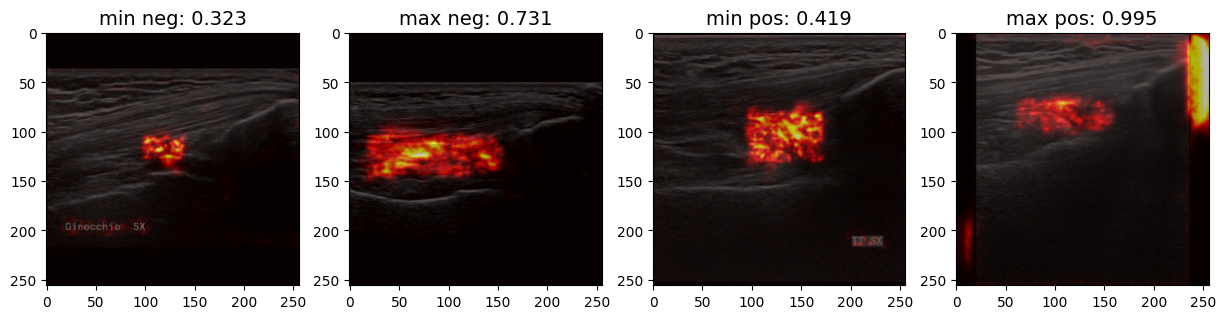

In [65]:
def plot_anomaly_maps_overlay(model, maps, originals, indices, labels):
    maps      = [ maps[model][i] for i in indices ]
    originals = [ originals[i]   for i in indices ]
    scores    = [ round(float(mapp.max()),3)     for mapp in maps ]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,7))
    plt.rcParams['font.size'] = '10'
    color = 'hot'
    alpha = 0.7
    
    ax1.imshow(originals[0])
    ax1.imshow(maps[0], alpha=alpha, cmap=color)
    ax1.set_title(f'{labels[0]}: {scores[0]}', size = 14)

    ax2.imshow(originals[1])
    ax2.imshow(maps[1], alpha=alpha, cmap=color)
    ax2.set_title(f'{labels[1]}: {scores[1]}', size = 14)

    ax3.imshow(originals[2])
    ax3.imshow(maps[2], alpha=alpha, cmap=color)
    ax3.set_title(f'{labels[2]}: {scores[2]}', size = 14)

    ax4.imshow(originals[3])
    ax4.imshow(maps[3], alpha=alpha, cmap=color)
    ax4.set_title(f'{labels[3]}: {scores[3]}', size = 14)

    
m_id = 3
indices = [which_min_neg, which_max_neg, which_min_pos, which_max_pos]
labels  = ['min neg', 'max neg', 'min pos', 'max pos']
plot_anomaly_maps_overlay(m_id, maps_test_ls, Y_test, indices, labels)
plt.savefig('../figures/model3_overlayed_maps.pdf')
plt.show()

Model3 has the best area under the ROC curve.

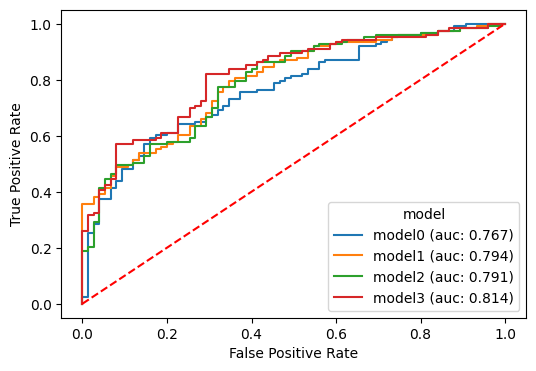

<Figure size 800x400 with 0 Axes>

In [43]:
def plot_roc_comparison(true_labels, anomaly_scores, params, criterion):
    fpr,  tpr,  _ = metrics.roc_curve(true_labels, anomaly_scores[0], pos_label='yes')
    fpr1, tpr1, _ = metrics.roc_curve(true_labels, anomaly_scores[1], pos_label='yes')
    fpr2, tpr2, _ = metrics.roc_curve(true_labels, anomaly_scores[2], pos_label='yes')
    fpr3, tpr3, _ = metrics.roc_curve(true_labels, anomaly_scores[3], pos_label='yes')
    aucs = [metrics.roc_auc_score(true_labels, anomaly_score) for anomaly_score in anomaly_scores]
    aucs = [round(float(a),3) for a in aucs]
    
    # - create ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr,  tpr)
    plt.plot(fpr1, tpr1)
    plt.plot(fpr2, tpr2)
    plt.plot(fpr3, tpr3)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend([f'{params[0]} (auc: {aucs[0]})', f'{params[1]} (auc: {aucs[1]})',
                f'{params[2]} (auc: {aucs[2]})', f'{params[3]} (auc: {aucs[3]})'], loc="lower right", title = criterion)
    plt.plot( [0,1],[0,1], color='red',linestyle='dashed')
    plt.show()
    
plot_roc_comparison(true_labels, anomaly_scores_test_ls, models_ids, 'model')
plt.savefig('../figures/aucroc.pdf')

Model3 is also the one that best separates the positive from the negative class.

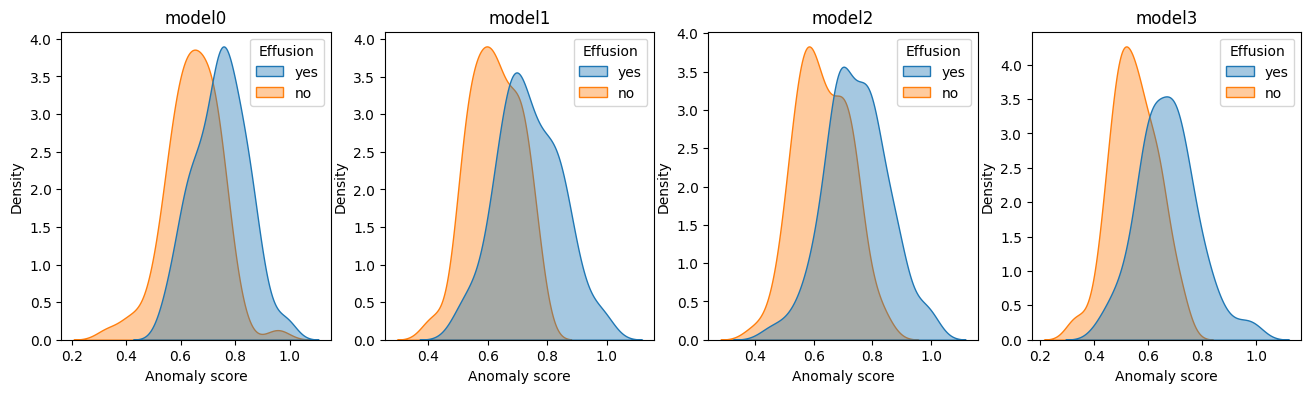

In [67]:
def plot_scores_density(anomaly_scores_ls, params):
    test_df["Anomaly_score"]  = anomaly_scores_ls[0]
    test_df["Anomaly_score1"] = anomaly_scores_ls[1]
    test_df["Anomaly_score2"]  = anomaly_scores_ls[2]
    test_df["Anomaly_score3"] = anomaly_scores_ls[3]
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))
    sns.kdeplot(data=test_df, x="Anomaly_score", hue="Effusion", fill=True, common_norm=False, alpha=0.4, ax=ax1)
    ax1.set_xlabel("Anomaly score")
    ax1.set_title(params[0])
    sns.kdeplot(data=test_df, x="Anomaly_score1", hue="Effusion", fill=True, common_norm=False, alpha=0.4, ax=ax2)
    ax2.set_xlabel("Anomaly score")
    ax2.set_title(params[1])
    sns.kdeplot(data=test_df, x="Anomaly_score2", hue="Effusion", fill=True, common_norm=False, alpha=0.4, ax=ax3)
    ax3.set_xlabel("Anomaly score")
    ax3.set_title(params[2])
    sns.kdeplot(data=test_df, x="Anomaly_score3", hue="Effusion", fill=True, common_norm=False, alpha=0.4, ax=ax4)
    ax4.set_xlabel("Anomaly score")
    ax4.set_title(params[3])

plot_scores_density(anomaly_scores_test_ls, models_ids)
plt.savefig('../figures/test_scores_density.pdf', bbox_inches='tight')
plt.show()

### F-score
Finally, the assessment of Model3's performance is done by computing the f-score. We select the classification threshold both by optimizing the base f-1 and f-beta, where beta is set to 1.1.

In [26]:
def predict_labels(scores, threshold):
    return ['yes' if score>=threshold else 'no' for score in scores]

def get_metrics(true_labels, scores):
    # compute metrics
    precision_scores = []
    recall_scores    = []
    f1_scores        = []
    fbeta_scores     = []
    for threshold in thresholds:
        pred_labels = predict_labels(scores, threshold)
        precision_scores.append(precision_score(true_labels, pred_labels, pos_label='yes'))
        recall_scores.append(recall_score(true_labels, pred_labels, pos_label='yes'))
        f1_scores.append(f1_score(true_labels, pred_labels, pos_label='yes'))
        fbeta_scores.append(fbeta_score(true_labels, pred_labels, beta=1.1, pos_label='yes'))
        
    return precision_scores, recall_scores, f1_scores, fbeta_scores

def get_best_metrics(precision_scores, recall_scores, f_scores, thresholds):
    # find best values
    best_id     = f_scores.index(np.max(f_scores))
    best_prec   = round(float(precision_scores[best_id]),3)
    best_recall = round(float(recall_scores[best_id]),3)
    best_f      = round(float(f_scores[best_id]),3)
    best_th     = round(float(thresholds[best_id]),2)
    
    return best_id, best_prec, best_recall, best_f, best_th


m_id = 3
thresholds = np.linspace(0.5,0.7,10)
scores = anomaly_scores_test_ls[m_id]
precision, recall, f1, fbeta = get_metrics(true_labels, scores)
best_id1, best_prec1, best_recall1, best_f1, best_th1 = get_best_metrics(precision, recall, f1,    thresholds)
best_id, best_prec, best_recall, best_fbeta, best_th  = get_best_metrics(precision, recall, fbeta, thresholds)

In [34]:
df = pd.DataFrame({
    'target metrics': ['f-1', 'f-beta'],
    'f-score'       : [best_f1, best_fbeta],
    'precision'     : [best_prec1, best_prec],
    'recall'        : [best_recall1, best_recall],
    'threshold'     : [best_th1,best_th]
})
df

,target metrics,f-score,precision,recall,threshold
0,f-1,0.816,0.820,0.813,0.59
1,f-beta,0.823,0.719,0.935,0.52


We can see how the threshold changes based on whether we assign more weight to recall. In any case, test performance is fairly good considering the difficult task.

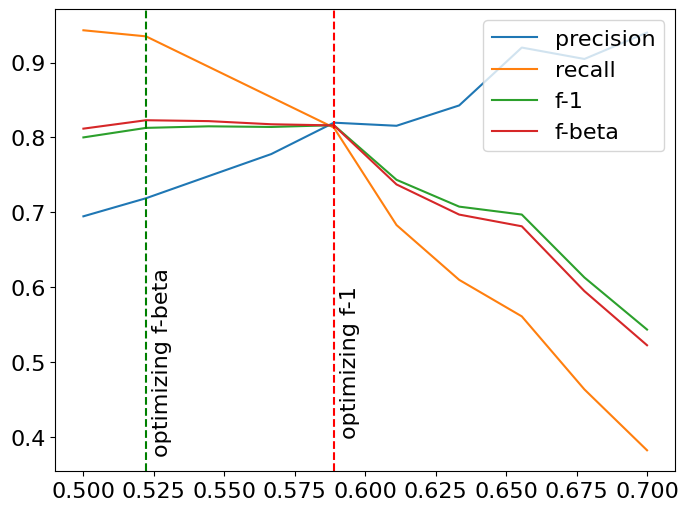

In [33]:
# plot
plt.rcParams["figure.figsize"]=8,6
plt.plot(thresholds,precision)
plt.plot(thresholds,recall)
plt.plot(thresholds,f1)
plt.plot(thresholds,fbeta)
plt.axvline(x = thresholds[best_id1], color="r",linestyle='dashed')
plt.axvline(x = thresholds[best_id], color="g",linestyle='dashed')
plt.text(thresholds[best_id1]+0.002, 0.5, 'optimizing f-1',   rotation=90, verticalalignment='center')
plt.text(thresholds[best_id]+0.002, 0.5, 'optimizing f-beta',rotation=90, verticalalignment='center')
plt.legend(['precision', 'recall', 'f-1', 'f-beta'], loc="upper right")